In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import *

import warnings
warnings.filterwarnings("ignore")

In [43]:
# data
winddir=pd.read_csv("winddir.csv")
winddir['Datetime'] = pd.to_datetime(winddir.Datetime, format='%Y/%m/%d')
data=np.asarray(winddir.iloc[:,1])

windspeed=pd.read_csv("windspeed.csv")
winddir['Datetime'] = pd.to_datetime(windspeed.Datetime, format='%Y/%m/%d')
speed=np.asarray(windspeed.iloc[:,1])

sep=int(len(data)*0.8)

# x分量，y分量，解矢量

In [44]:
sindata,cosdata=data.copy(),data.copy()
for i in range(len(data)):
    sindata[i]=speed[i]*sin(radians(data[i]))
    cosdata[i]=speed[i]*cos(radians(data[i]))

In [45]:
def tovec(y,x):
    """解矢量，输入分别为y分量和x分量，输出为角度和模"""
    module=hypot(x,y)
    if module==0:
        return 0,0
    cosv,sinv=x/module,y/module
    if cosv==0:
        if sinv>=0:
            return 90, module
        else:
            return 270, module
    tanv=sinv/cosv
    ans=atan(tanv)
    if cosv<0:
        ans+=pi
    if cosv>0 and tanv<0:
        ans+=2*pi
    return degrees(ans), module

In [46]:
d,m=tovec(0,-1)
d,m

(180.0, 1.0)

# 尝试AR

In [47]:
from statsmodels.tsa.ar_model import AutoReg
trains,tests,trainc,testc = sindata[:sep],sindata[sep:],cosdata[:sep],cosdata[sep:]

## y分量

In [74]:
# 从1至10遍历找最优自回归阶数,sin
bestlags,mse=1,100
for i in range(10):
    ar = AutoReg(trains,lags=i,trend='n',seasonal=True,period=365).fit()  #
    ar_fit = ar.predict(start=0,end=len(trains)-1+i)  # 我们进行拟合
    if mse > mean_squared_error(trains,ar_fit):
        bestlags, mse = i, mean_squared_error(trains,ar_fit)
    
ar = AutoReg(trains,lags=bestlags,trend='n',seasonal=True,period=365).fit()  #
sin_fit = ar.predict(start=0,end=len(trains)-1+bestlags)
sin_pre = ar.predict(start=len(trains),end=len(trains)+len(tests)-1)  # 这里是预测了

bestlags

1

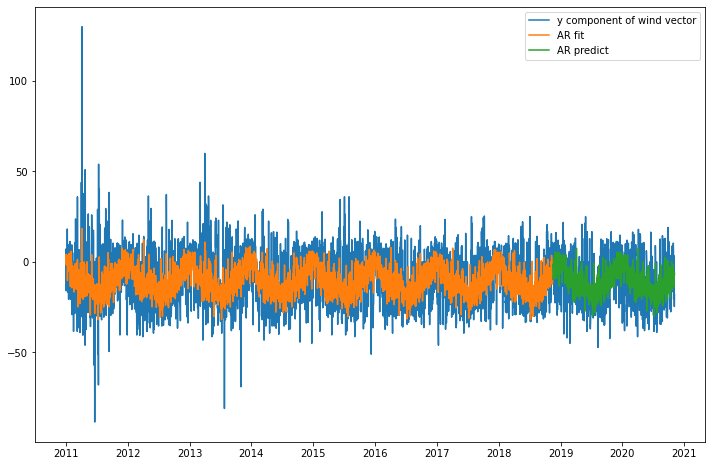

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime, sindata, label='y component of wind vector')
plt.plot(winddir.Datetime[:sep], sin_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], sin_pre, label='AR predict')
plt.legend()

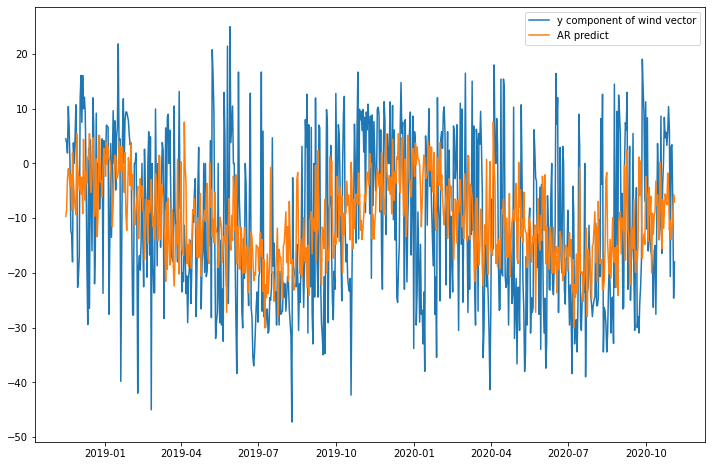

In [76]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime[sep:], sindata[sep:], label='y component of wind vector')
# plt.plot(winddir.Datetime[:sep], sin_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], sin_pre, label='AR predict')
plt.legend()

In [51]:
# mean square error
mse = mean_squared_error(tests,sin_pre)
print("mse of AR: ", mse)
# 224.47148515498137

mse of AR:  224.47148515498137


## x分量

In [77]:
# 从1至10遍历找最优自回归阶数,cos
bestlags,mse=1,100
for i in range(10):
    ar = AutoReg(trainc,lags=i,trend='n',seasonal=True,period=365).fit()  #
    ar_fit = ar.predict(start=0,end=len(trainc)-1+i)  # 我们进行拟合
    if mse > mean_squared_error(trainc,ar_fit):
        bestlags, mse = i, mean_squared_error(trainc,ar_fit)
    
ar = AutoReg(trainc,lags=bestlags,trend='n',seasonal=True,period=365).fit()  #
cos_fit = ar.predict(start=0,end=len(trainc)-1+bestlags)
cos_pre = ar.predict(start=len(trainc),end=len(trainc)+len(testc)-1)  # 这里是预测了

bestlags

1

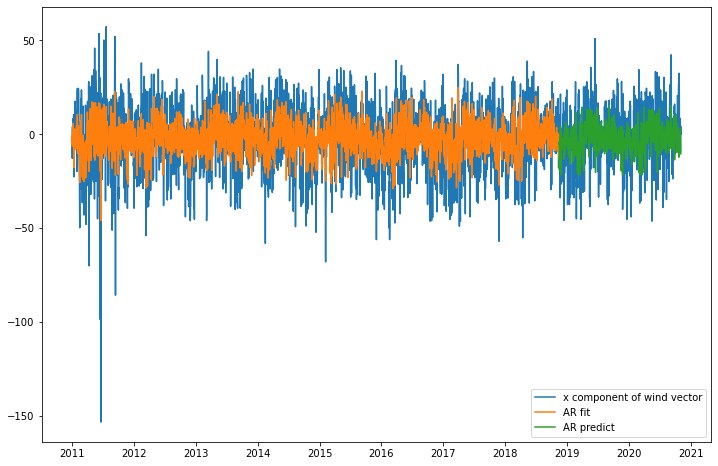

In [78]:
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime, cosdata, label='x component of wind vector')
plt.plot(winddir.Datetime[:sep], cos_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], cos_pre, label='AR predict')
plt.legend()

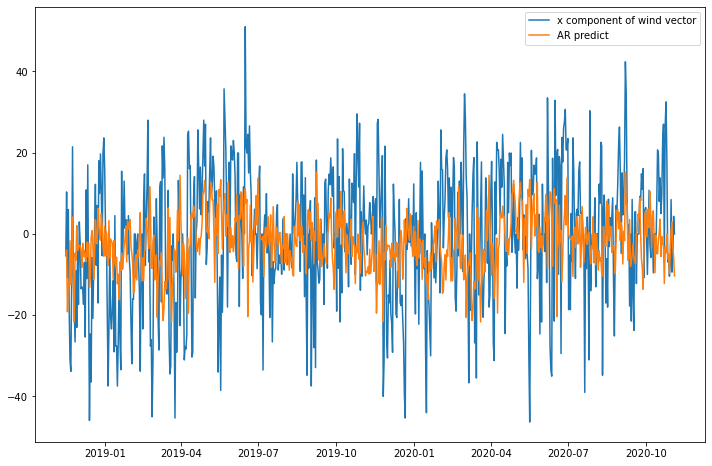

In [79]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime[sep:], cosdata[sep:], label='x component of wind vector')
# plt.plot(winddir.Datetime[:sep], cos_fit, label='AR fit')
plt.plot(winddir.Datetime[sep:], cos_pre, label='AR predict')
plt.legend()

In [80]:
# mean square error
mse = mean_squared_error(testc,cos_pre)
print("mse of AR: ", mse)
# 288.4504004145219

mse of AR:  288.4504004145219


# 通过x、y分量还原风向、风速

In [56]:
ar_fit_dir,ar_pre_dir=sin_fit.copy(),sin_pre.copy()
ar_fit_speed,ar_pre_speed=sin_fit.copy(),sin_pre.copy()
for i in range(len(ar_fit_dir)):
    ar_fit_dir[i],ar_fit_speed[i]=tovec(sin_fit[i],cos_fit[i])
for i in range(len(ar_pre_dir)):
    ar_pre_dir[i],ar_pre_speed[i]=tovec(sin_pre[i],cos_pre[i])

## 风向

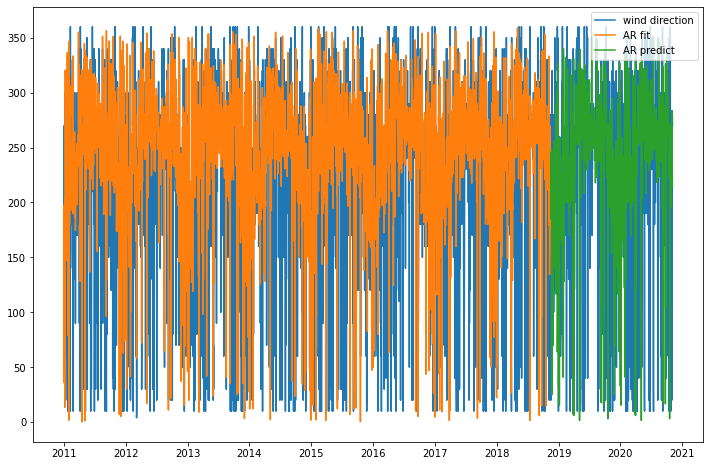

In [57]:
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime, data, label='wind direction')
plt.plot(winddir.Datetime[:sep], ar_fit_dir, label='AR fit')
plt.plot(winddir.Datetime[sep:], ar_pre_dir, label='AR predict')
plt.legend()

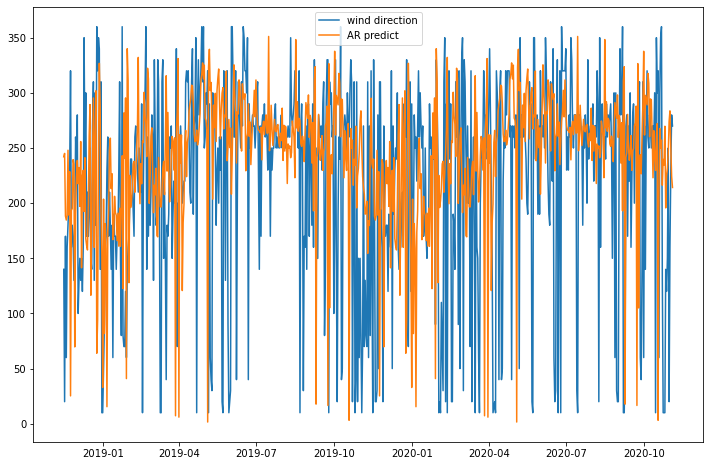

In [58]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime[sep:], data[sep:], label='wind direction')
# plt.plot(winddir.Datetime[:sep], ar_fit_dir, label='AR fit')
plt.plot(winddir.Datetime[sep:], ar_pre_dir, label='AR predict')
plt.legend()

In [59]:
# mean square error
mse = mean_squared_error(data[sep:],ar_pre_dir)
print("mse of AR: ", mse)
# 12823.578165330513

mse of AR:  12823.578165330513


In [60]:
pd.DataFrame(np.concatenate([ar_fit_dir,ar_pre_dir])).to_csv('result_AR_winddir_vector.csv',index = False)
# 预测的结果，有预测值和拟合值

## 风速

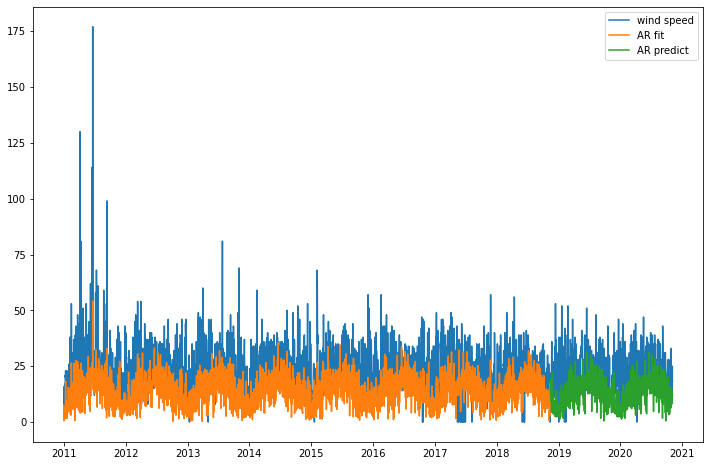

In [61]:
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime, speed, label='wind speed')
plt.plot(winddir.Datetime[:sep], ar_fit_speed, label='AR fit')
plt.plot(winddir.Datetime[sep:], ar_pre_speed, label='AR predict')
plt.legend()

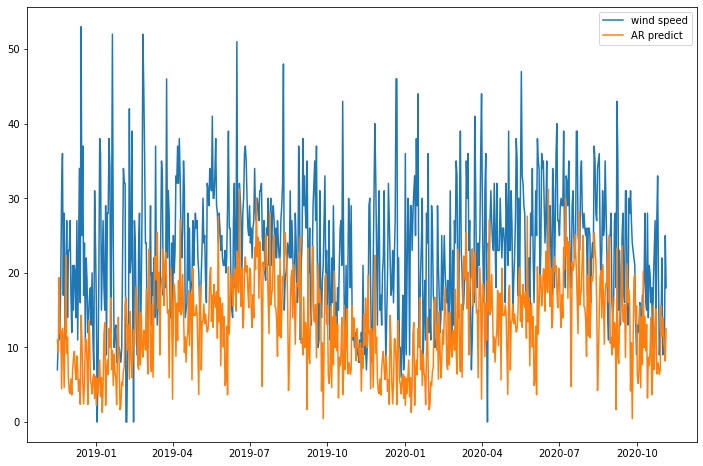

In [62]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime[sep:], speed[sep:], label='wind speed')
# plt.plot(winddir.Datetime[:sep], ar_fit_speed, label='AR fit')
plt.plot(winddir.Datetime[sep:], ar_pre_speed, label='AR predict')
plt.legend()

In [63]:
# mean square error
mse = mean_squared_error(speed[sep:],ar_pre_speed)
print("mse of AR: ", mse)
# 191.36516453098213

mse of AR:  191.36516453098213


In [64]:
pd.DataFrame(np.concatenate([ar_fit_speed,ar_pre_speed])).to_csv('result_AR_winddir_speed.csv',index = False)
# 预测的结果，有预测值和拟合值

# 直接AR预测风速

In [68]:
# 从1至10遍历找最优自回归阶数
bestlags,mse=1,100
train,test=speed[:sep],speed[sep:]
for i in range(10):
    ar = AutoReg(train,lags=i,trend='n',seasonal=True,period=365).fit()  #
    ar_fit = ar.predict(start=0,end=len(train)-1+i)  # 我们进行拟合
    if mse > mean_squared_error(train,ar_fit):
        bestlags, mse = i, mean_squared_error(train,ar_fit)
    
ar = AutoReg(train,lags=bestlags,trend='n',seasonal=True,period=365).fit()  #
ar_fit = ar.predict(start=0,end=len(train)-1+bestlags)
ar_pre = ar.predict(start=len(train),end=len(train)+len(test)-1)  # 这里是预测了

bestlags

1

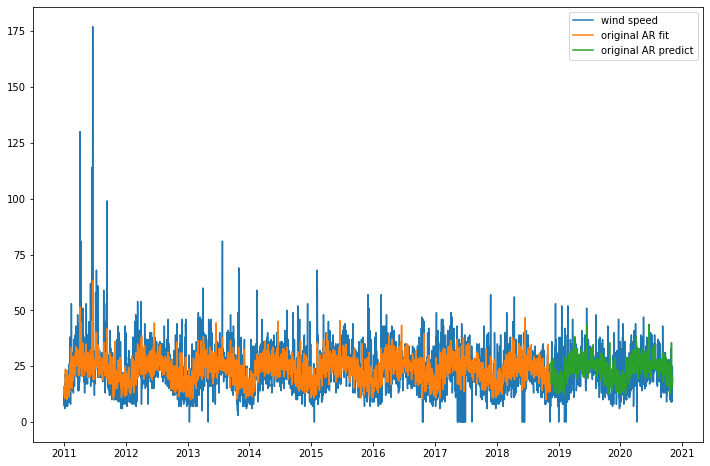

In [69]:
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime, speed, label='wind speed')
plt.plot(winddir.Datetime[:sep], ar_fit, label='original AR fit')
plt.plot(winddir.Datetime[sep:], ar_pre, label='original AR predict')
plt.legend()

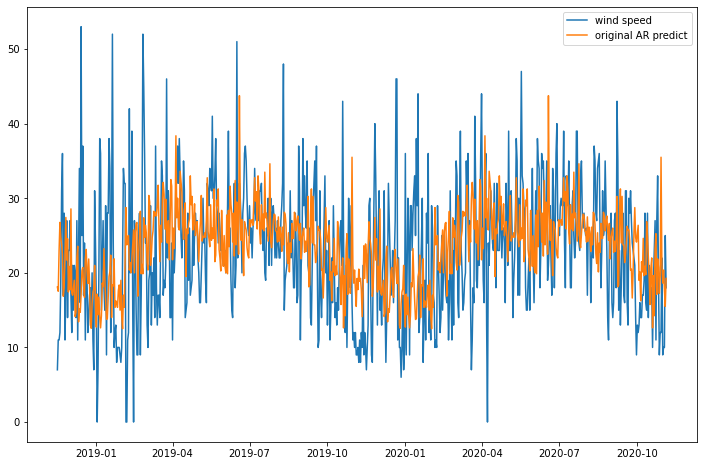

In [70]:
# 这个图只有预测的部分
plt.figure(figsize=(12, 8))
plt.plot(winddir.Datetime[sep:], speed[sep:], label='wind speed')
# plt.plot(winddir.Datetime[:sep], ar_fit, label='original AR fit')
plt.plot(winddir.Datetime[sep:], ar_pre, label='original AR predict')
plt.legend()

In [71]:
# mean square error
mse = mean_squared_error(speed[sep:],ar_pre)
print("mse of AR: ", mse)
# 矢量方法是191.36516453098213
# 86.36059063586748

mse of AR:  86.36059063586748


In [72]:
pd.DataFrame(np.concatenate([ar_fit_speed,ar_pre_speed])).to_csv('result_AR_speed_original.csv',index = False)
# 预测的结果，有预测值和拟合值